In [1]:
#| eval: true
#| echo: false
from IPython.display import Markdown, display

In [2]:
#| eval: false
#| echo: true
# japanize_matplotlibのインストール
!pip install -qq japanize_matplotlib

In [3]:
# このファイルのコードの実行に利用するライブラリを読み込む
import japanize_matplotlib  # matplotlibの日本語化
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [4]:
# 指数表示を禁止、小数点以下5桁まで表示
pd.options.display.float_format = '{:.5f}'.format

回帰モデルでは、目的変数$y$を説明変数$x$によって予測することを考えます。線形回帰モデルでは、目的変数$y$と説明変数$x$の関係を次のように仮定します。

$$
y = \beta_0 + \beta_1 x + \epsilon
$$

一次関数によって表されるこの関係を単回帰モデルと呼びます。ここで、$\beta_0$ は切片、$\beta_1$ は傾き、$\epsilon$ は誤差を表します。誤差は誤差項と呼ばれ、モデルで説明できない部分を表します。誤差項は、平均が0で分散が均一（均一分散）の正規分布に従うと仮定します。

この式を使って、目的変数 $y$ を説明変数 $x$ によって予測することを考えます。このとき、説明変数 $x$ の値が与えられたときの目的変数 $y$ の期待値 $E[y]$ は次のようになります。

$$
\begin{align}
E[y] = E[\beta_0 + \beta_1 x + \epsilon] \\
= \beta_0 + \beta_1 E[x] + E[\epsilon] \\
= \beta_0 + \beta_1 E[x]
\end{align}
$$

<!-- 2つ目の等号では、期待値の性質である線形性を利用しています。 -->

誤差項の期待値は普通、0として扱われます。この式から、単回帰モデルにおける $y$ の期待値は、切片 $\beta_0$ と説明変数 $x$ の期待値に、傾き $\beta_1$ を掛けた値の和となります。

単回帰モデルの例を見てみましょう。南極大陸に生育するペンギンのデータセットを使います。ここからペンギンの翼の長さから体重を予測するモデルを作成します。


In [5]:
penguins = sns.load_dataset("penguins")
# 欠損値を含む行を除外
penguins.dropna(inplace=True)

散布図により、翼の長さと体重の関係を可視化します。この図からは翼の長さが長い個体は体重も大きい傾向が読み取れます。


/Users/suryu/Documents/teaching/23_exeai/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/suryu/Documents/teaching/23_exeai/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



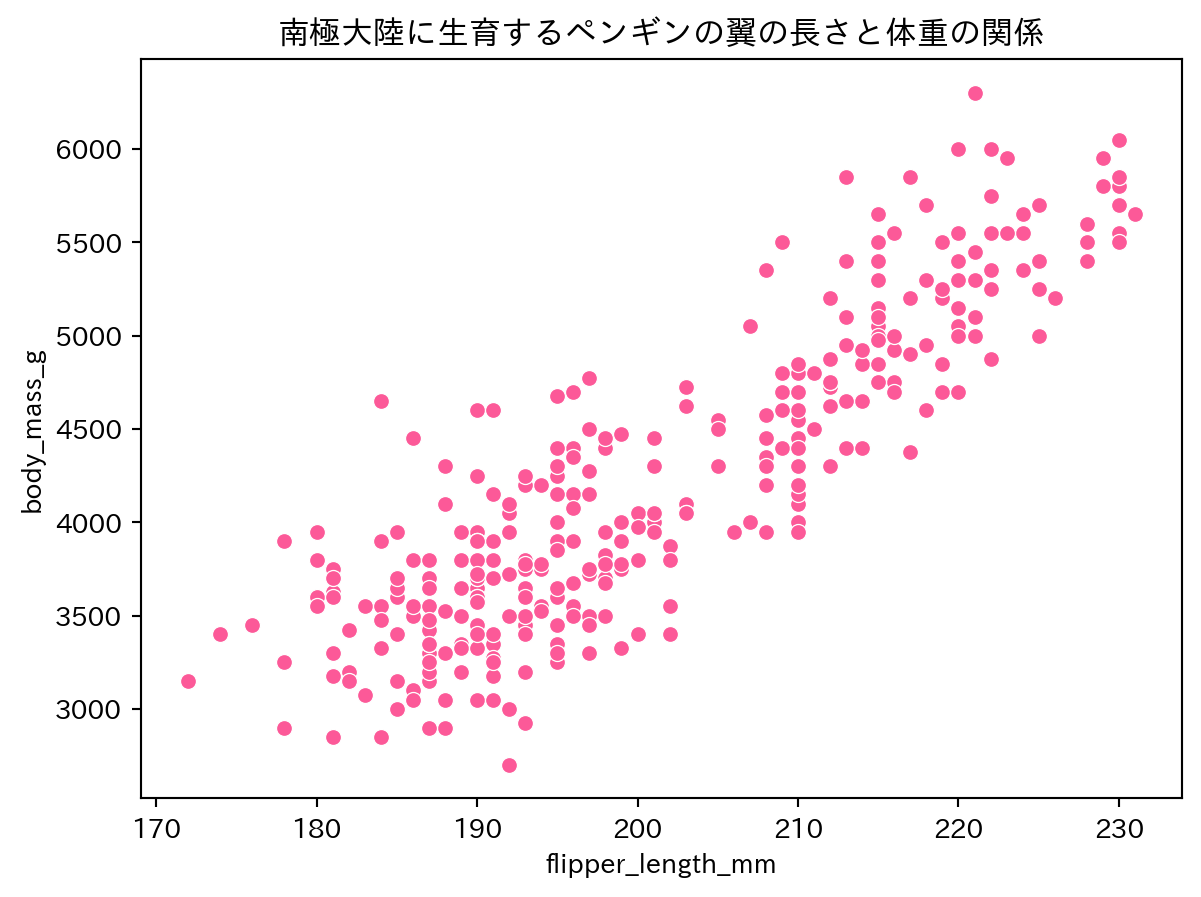

In [6]:
# 散布図の作成
sns.scatterplot(data=penguins, x="flipper_length_mm", y="body_mass_g", color="#fc5998")
plt.title("南極大陸に生育するペンギンの翼の長さと体重の関係")
plt.show()

In [7]:
# 回帰モデルの構築
lr = LinearRegression()
lr.fit(
    X = penguins[["flipper_length_mm"]], 
    y = penguins["body_mass_g"])

LinearRegression()

傾きと切片を確認します。傾きは係数 `coef_` に、切片は切片 `intercept_` に格納されています。


In [8]:
pd.DataFrame({
    "beta_0": lr.intercept_, # 切片
    "beta_1": lr.coef_ # 傾き
})

,beta_0,beta_1
0,-5872.09268,50.15327


切片は、翼の長さが0のときの体重を表します。翼の長さが0のときの体重は、生物学的に意味をなさないので、この値はあまり意味をなしません。一方、傾きは、翼の長さが1mm長くなると体重がどれだけ増えるかを表します。この値は、翼の長さが0のときの体重とは異なり、「翼の長さが1mm長くなると増える体重」という意味を持ちます。具体的には $\beta_1$ の値は約50であり、翼の長さが1mm長くなると体重が約50g増えることを意味します。


In [9]:
# モデルの予測値を計算
# 1行目のデータを数値として扱う
x = penguins[["flipper_length_mm"]][0:1]
print(x)

lr.predict(x)

   flipper_length_mm
0          181.00000


array([3205.6484527])

モデルによる予測値は、切片と傾きを使って計算されます。すでに切片と傾きを確認したので、この値を使って予測値を計算してみましょう。


In [10]:
# モデルの予測値が計算できることを確認
lr.intercept_ + lr.coef_ * x.values

array([[3205.6484527]])

### 予測精度

回帰モデルの善し悪しは、予測精度によって評価されます。予測精度にはいくつか種類がありますが、ここでは決定係数と呼ばれる指標を使って予測精度を評価します。決定係数は、実際の値と予測値の差を使って計算されます。この差を残差と呼びます。残差は、実際の値から予測値を引くことで計算されます。


In [11]:
# モデルの予測値を計算
y_pred = lr.predict(penguins[["flipper_length_mm"]])
# 残差を計算
residual = penguins["body_mass_g"] - y_pred

残差を使って決定係数を計算します。決定係数は以下の式で計算されます。

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

ここで分母の $\sum_{i=1}^n (y_i - \bar{y})^2$ は、実際の値と平均値の差の2乗の和を表します。これは、実際の値のばらつき（分散）を表します。一方、分子の $\sum_{i=1}^n (y_i - \hat{y}_i)^2$ は、実際の値と予測値の差（残差）のばらつきを表します。決定係数は、実際の値と予測値の差のばらつきを、実際の値のばらつきで割った値です。この値は、0から1の間の値を取ります。1に近いほど、実際の値と予測値の差のばらつきが小さいことを意味します。つまり、予測精度が高いことを意味します。


In [12]:
# 決定係数を計算
1 - np.var(residual) / np.var(penguins["body_mass_g"])

0.7620921573403914

決定係数の値が意味する内容は、以下のように解釈できます。

「ペンギンの翼の長さによって、体重を約76%の精度で予測できることを意味する。」

scikit-learnでは、scoreメソッドを用いて、説明変数と目的変数を与えることで決定係数を計算できます。


In [13]:
# 決定係数を計算
lr.score(penguins[["flipper_length_mm"]], penguins["body_mass_g"])

0.7620921573403914

## 重回帰モデル

単回帰モデルでは入力変数が1つだけでしたが、現実の問題では、入力変数が1つだけではなく、複数ある場合が多いです。例えば、ペンギンの体重を予測する場合、翼の長さだけでなく、体の長さや体の深さなどの情報も、予測したいモデルの入力として使うことができます。このように、入力変数が1つだけではなく、複数ある場合の回帰モデルを重回帰モデルと呼びます。重回帰モデルは、次の式で表されます。

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k + \epsilon
$$

ここで、$y$ は目的変数、$x_1, x_2, \ldots, x_k$ は説明変数、$\beta_0, \beta_1, \ldots, \beta_k$ はパラメータ、$\epsilon$ は誤差を表します。

<!-- 標準化を行わない -->


In [14]:
def coefficient_table(model, X_vars):
    # モデルの係数を取得
    coefs = model.coef_

    # 特徴量の名前を取得
    feature_names = X_vars

    # データフレームにまとめる
    df_coef = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    })
    df_coef['Feature'] = df_coef['Feature'].str.split('__').str[-1]
    df_coef["abs_coef"] = np.abs(df_coef["Coefficient"])
    df_coef = df_coef.sort_values("abs_coef", ascending=False).drop(columns="abs_coef")
    return df_coef

ペンギンデータの体重以外の変数を説明変数として、線形回帰モデルを学習させます。


In [15]:
# カテゴリ変数についてワンホットエンコーディングを指定
column_trans = make_column_transformer((OneHotEncoder(), ['species', 'island', 'sex']), remainder='passthrough')

# パイプラインを作成
# 前処理・特徴量エンジニアリングとモデル（線形回帰モデル）を組み合わせる
pipe = make_pipeline(column_trans, lr)

In [16]:
# モデルの学習
# 体重以外の変数を説明変数として、線形回帰モデルを学習させる
pipe.fit(penguins.drop(columns="body_mass_g"), penguins["body_mass_g"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['species', 'island',
                                                   'sex'])])),
                ('linearregression', LinearRegression())])

重回帰モデルでも係数を元にモデルの予測値がどのように計算されたかを確認することができます。具体的には予測に使われたデータに対して係数をかけて足し合わせることで予測値を計算します。


In [17]:
# 1行目のデータを取得
x = penguins.drop(columns="body_mass_g").iloc[[0]]
x

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,Adelie,Torgersen,39.10000,18.70000,181.00000,Male


In [18]:
# 予測値を計算
pipe.predict(x)

array([3753.16389596])

In [19]:
transformed_data = pipe.named_steps["columntransformer"].transform(penguins.drop(columns="body_mass_g"))
# データフレームに変換
df_transformed = pd.DataFrame(transformed_data, columns=pipe.named_steps['columntransformer'].get_feature_names_out())

# 1行目のデータの予測値を計算
pipe.named_steps['linearregression'].intercept_ + np.dot(df_transformed.iloc[[0]], pipe.named_steps['linearregression'].coef_)

array([3753.16389596])

単回帰モデル同様、切片と係数を利用してモデルの予測値を得ることができました。

重回帰モデルでの係数の値は、説明変数の重要度を表します。係数の絶対値が大きいほど、その説明変数が目的変数の値の予測に対して重要であることを表します。係数の値が正のときには、説明変数が増加すると目的変数の値も増加することを表します。一方、係数の値が負のときには、説明変数が増加すると目的変数の値は減少することを表します。

このことを踏まえてペンギンの体重を予測する重回帰モデルの係数を確認すると、次のことがわかります。


In [20]:
# 係数を確認
df_coef = coefficient_table(
  pipe.named_steps['linearregression'],
  pipe.named_steps['columntransformer'].get_feature_names_out())
df_coef

,Feature,Coefficient
2,species_Gentoo,745.27639
1,species_Chinstrap,-502.79134
0,species_Adelie,-242.48505
7,sex_Male,193.61213
6,sex_Female,-193.61213
9,bill_depth_mm,67.57543
5,island_Torgersen,-27.67473
3,island_Biscoe,20.38889
8,bill_length_mm,18.18932
10,flipper_length_mm,16.23851


まず、係数の絶対値の大きなペンギンの種類の違いが体重に影響を与えてます。ジェンツーペンギンでは係数が正ですが、他の2種は係数が負の値です。これはジェンツーペンギン、ヒゲペンギン、アデリーペンギンの順に体重が大きく、ジェンツーペンギンはアデリーペンギンよりも体重が約1000g大きいことがわかります。この傾向はグラフからも読み取ることができます。


/Users/suryu/Documents/teaching/23_exeai/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/suryu/Documents/teaching/23_exeai/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/suryu/Documents/teaching/23_exeai/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



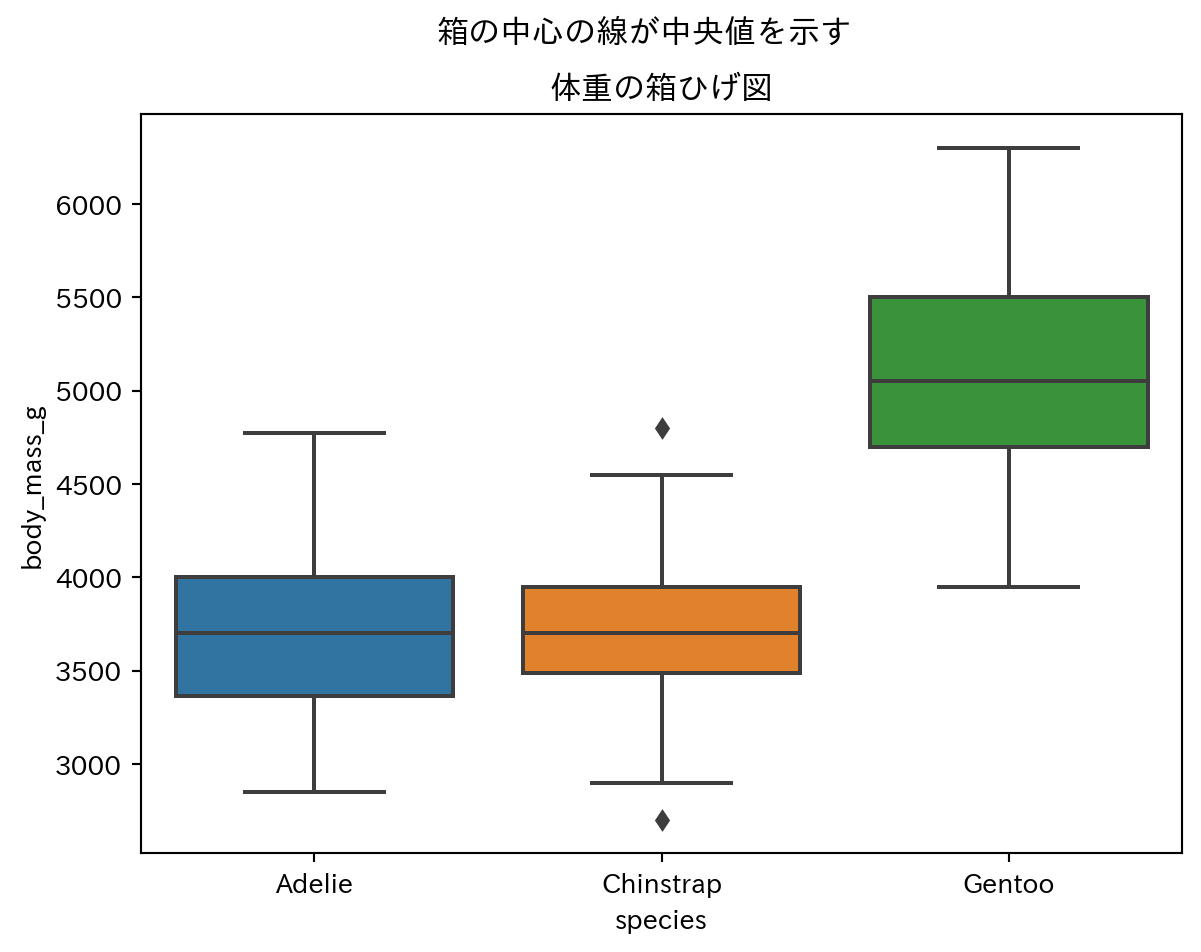

In [21]:
# 箱ひげ図を描画
sns.boxplot(data=penguins, x="species", y="body_mass_g")
plt.title("体重の箱ひげ図")
plt.suptitle("箱の中心の線が中央値を示す")
plt.show()

また、種類に続いて性別の違いも体重に与える影響も大きくなっています。係数の値は、性別が雄の場合は雌の場合よりも体重が約500g大きいことを意味します。


In [22]:
# オスとメスそれぞれの体重の平均値を計算
# ペンギンの雄の体重の平均値
penguins.groupby("sex")["body_mass_g"].mean()

sex
Female   3862.27273
Male     4545.68452
Name: body_mass_g, dtype: float64

その他、数値変数の中ではくちばしの太さ `bill_depth_mm` の係数が大きくなっています。`bill_depth_mm`の係数は67.5となっています。これはくちばしの太さが1mm大きくなると体重が67.5g増加することを意味します。ただし、この値は他の変数が固定されている前提で計算された値です。

`bill_length_mm`、`flipper_lenth_mm`については、係数の絶対値が小さくなっています。そのため、これらの変数が体重に与える影響は、くちばしの太さよりも小さいということでしょうか。こうした変数間での係数の絶対値を比較することはできません。なぜなら、係数の絶対値は説明変数の値の範囲に依存するためです。これは、説明変数の値の範囲が広い変数では、その値が一単位変化したときの目的変数の変化量が相対的に小さくなるために係数が小さくなってしまうことがあるためです。これは特に異なる単位の変数を同時に利用する場合に問題となります。

具体例を見てみましょう。`bill_length_mm`、`bill_depth_mm`、`flipper_length_mm`の値の範囲を確認すると、`flipper_length_mm`の値の範囲が最も大きいことがわかります。このことから`flipper_length_mm`の値の範囲が広いために、その値が一単位変化したときの目的変数の変化量が相対的に小さくなることを意味します。


In [23]:
# 変数の範囲を確認
# くちばしの長さ
for col in ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]:
    print(col, penguins[col].min(), "から", penguins[col].max())

bill_length_mm 32.1 から 59.6
bill_depth_mm 13.1 から 21.5
flipper_length_mm 172.0 から 231.0


数値変数の値の範囲を揃えるために、数値変数を標準化してからモデルを学習させることを考えます。これにより、係数の大きさを比較できるようになります。

### 標準化後の係数の解釈

数値変数に対して、平均0、標準偏差1となるような標準化を行います。これにより、数値変数の値の範囲を揃えることができ、変数間での比較を行えるようになります。


In [24]:
# 特定の列にOneHotEncoder()を適用
one_hot_cols = ['species', 'island', 'sex']
# 特定の列にStandardScaler()を適用
scale_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']

# make_column_transformer()を使用してトランスフォーマを作成
column_trans = make_column_transformer(
    (OneHotEncoder(), one_hot_cols),
    (StandardScaler(), scale_cols),
    remainder='passthrough'
)

# パイプラインを作成
#pipe = Pipeline([
#    ('preprocessor', column_trans),
#    ('model', lr)
#])

pipe = make_pipeline(column_trans, lr)

In [25]:
# モデルの学習
pipe.fit(penguins.drop(columns="body_mass_g"), penguins["body_mass_g"])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['species', 'island', 'sex']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('linearregression', LinearRegression())])

In [26]:
# 特徴量と係数の対応を確認
df_coef_std = coefficient_table(
  pipe.named_steps['linearregression'],
  pipe.named_steps['columntransformer'].get_feature_names_out())

df_coef_std["abs_coef"] = np.abs(df_coef_std["Coefficient"])

# 元が数値変数だった特徴量の係数を取得
df_coef_std.query('Feature in @scale_cols').sort_values("abs_coef", ascending=False).drop(columns="abs_coef")

,Feature,Coefficient
10,flipper_length_mm,251.74725
9,bill_depth_mm,129.22946
8,bill_length_mm,104.53889


係数の値が大きいのは`flipper_length_mm`、`bill_depth_mm`、`bill_length_mm`の順番です。このことは3種の変数の中で体重に影響を与えるのは`flipper_length_mm`が最も大きいということです。

散布図や相関係数からも、`flipper_length_mm`が体重に影響を与えることがわかります。


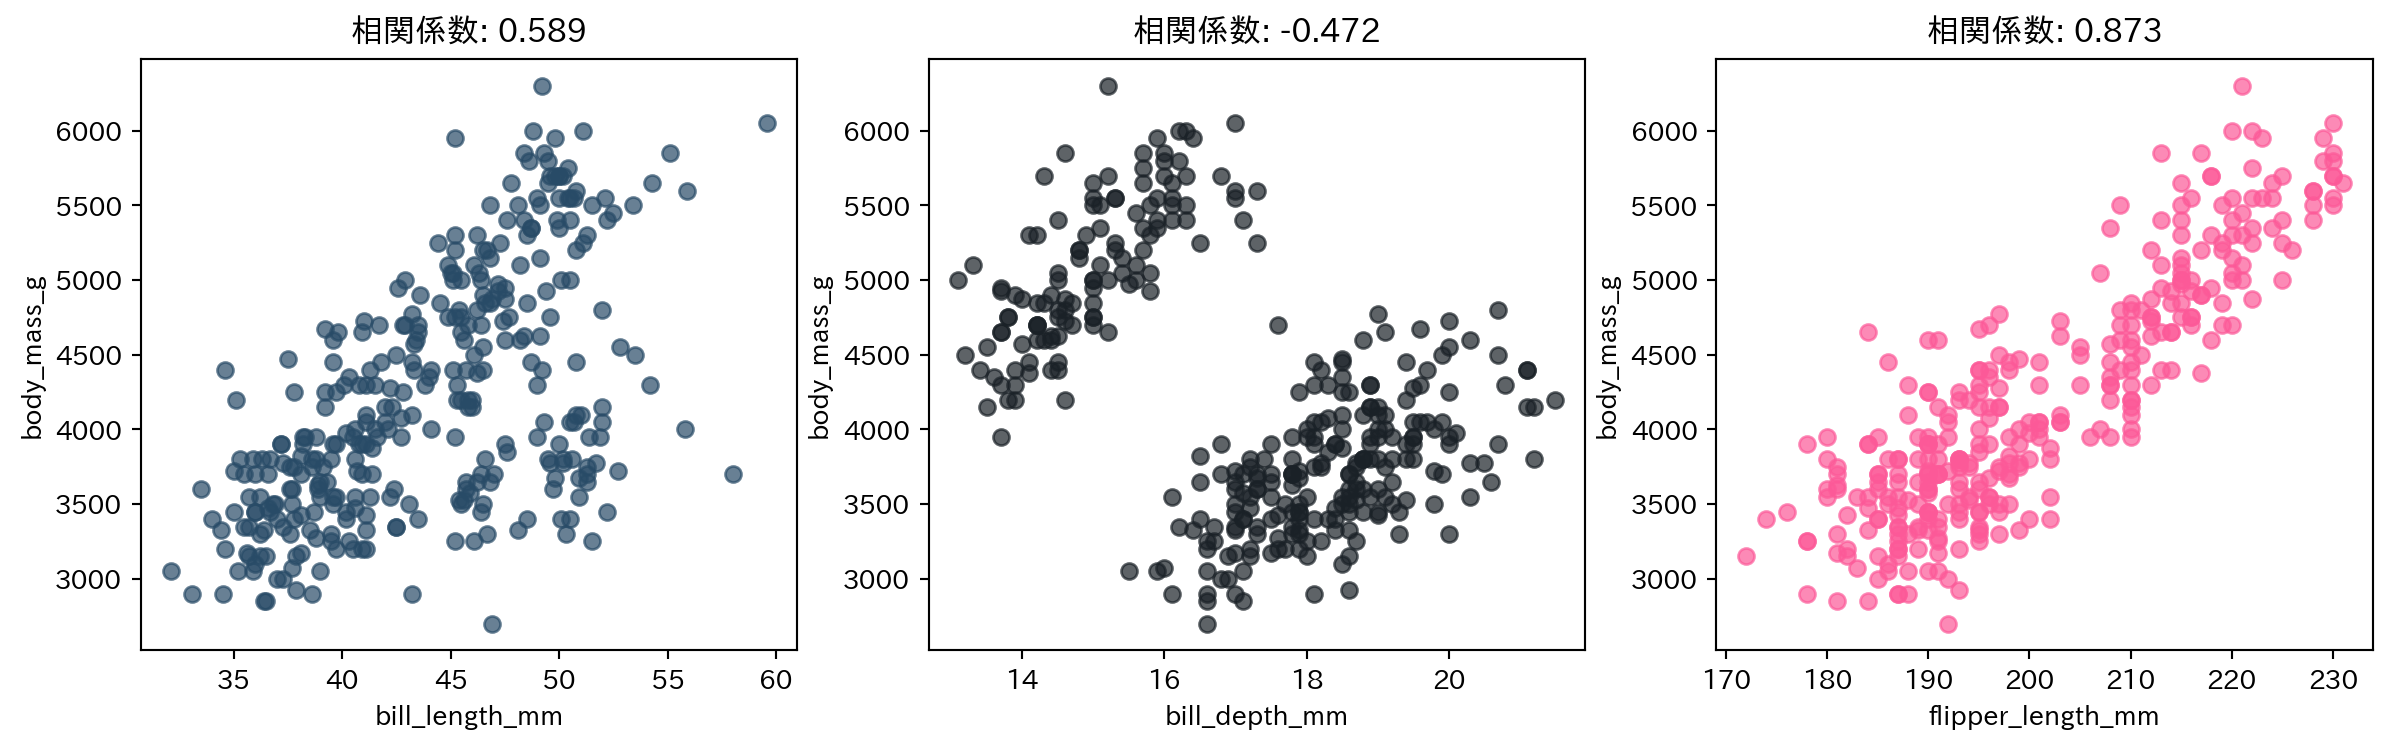

In [27]:
# 3つの図を並べて描画
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# 3つの数値変数と体重の散布図を描画
# 図ごとに色を変える
for ax, col, color in zip(axes, scale_cols, ["#284b67", "#1a2127", "#fc5998"]):
    ax.scatter(penguins[col], penguins["body_mass_g"], color=color, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("body_mass_g")
    ax.set_title(f"相関係数: {penguins[col].corr(penguins['body_mass_g']):.3f}")
plt.show()

最後に、重回帰モデルでの決定係数を計算しましょう。重回帰モデルの決定係数は、単回帰モデルの決定係数と同様に、0から1の値をとり、1に近いほど目的変数を説明できていることを意味します。


In [28]:
# 決定係数を計算
pipe.score(penguins.drop(columns="body_mass_g"), penguins["body_mass_g"])

0.8725458488320944

この値は説明変数の標準化を行ったあとでのモデルの決定係数ですが、実は説明変数の標準化を行わない場合でも同じ値になります。これは、重回帰モデルの決定係数は、説明変数の標準化を行っても行わなくても同じ値になるためです。つまり、モデルの精度には標準化の有無は影響を与えません。